# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style("whitegrid")
import yfinance as yf
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def d(*obj):
    for o in obj:
        display(o)

def p(*obj):
    for o in obj:
        print(o)

def _np(ls):
    return np.array(ls)

def r(f, unit=3):
    return round(f, unit)

/Users/kyro_m3pro/Desktop/Backtesting/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Get Data

In [2]:
def str_to_float(x:str):
    if type(x) == str:
        return float(x.replace(',' ,''))
    else:
        return x
    
vixf = pd.read_csv('Data/VIXF.csv').set_index('Date')[::-1]
vixf.index = pd.to_datetime(pd.to_datetime(vixf.index).strftime('%Y-%m-%d'))

cols_to_convert = ["Open", "High", "Low", "Price"]
for col in cols_to_convert:
    vixf[col] = vixf[col].apply(str_to_float)

In [3]:
spx = pd.read_csv('Data/SPX.csv', index_col='Date')
spx.index = pd.to_datetime(spx.index)

vix = pd.read_csv('Data/VIX.csv', index_col='Date')
vix.index = pd.to_datetime(vix.index)

In [4]:
df = pd.concat([spx['Adj Close'].rename('SPX'),
                vix['Adj Close'].rename('VIX'),
                vixf['Price'].rename('VIXF')], axis=1)
df = df.dropna()

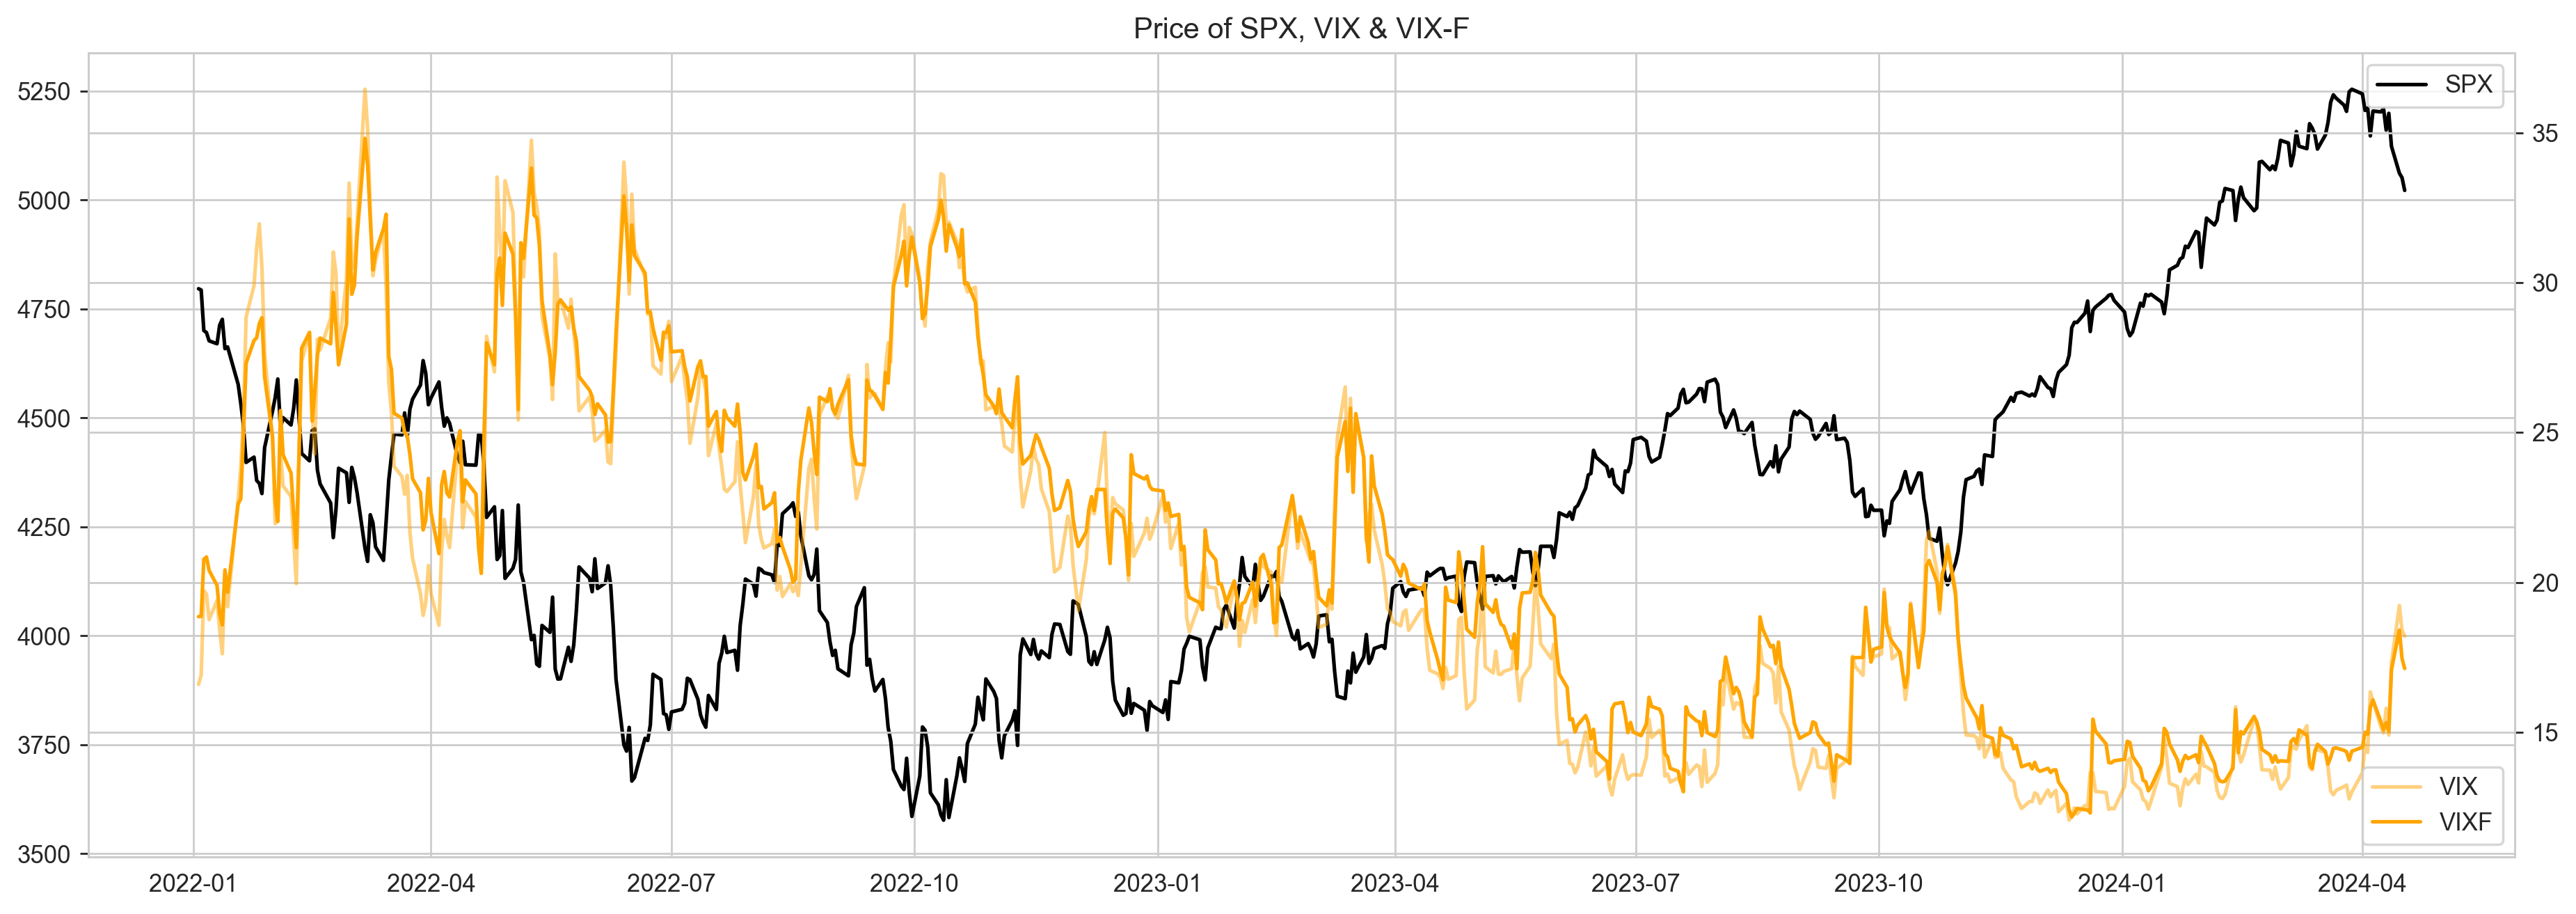

In [7]:
figsize = (18, 6)
fig, ax1 = plt.subplots(figsize=figsize, dpi=250)
ax2 = ax1.twinx()
ax1.plot(df['SPX'], c='black', label='SPX', alpha=1)
ax1.legend(loc=1)

ax2.plot(df['VIX'], c='orange', label='VIX', alpha=0.5)
ax2.plot(df['VIXF'], c='orange', label='VIXF', alpha=1)
ax2.legend(loc=4)
plt.title('Price of SPX, VIX & VIX-F')
plt.show()

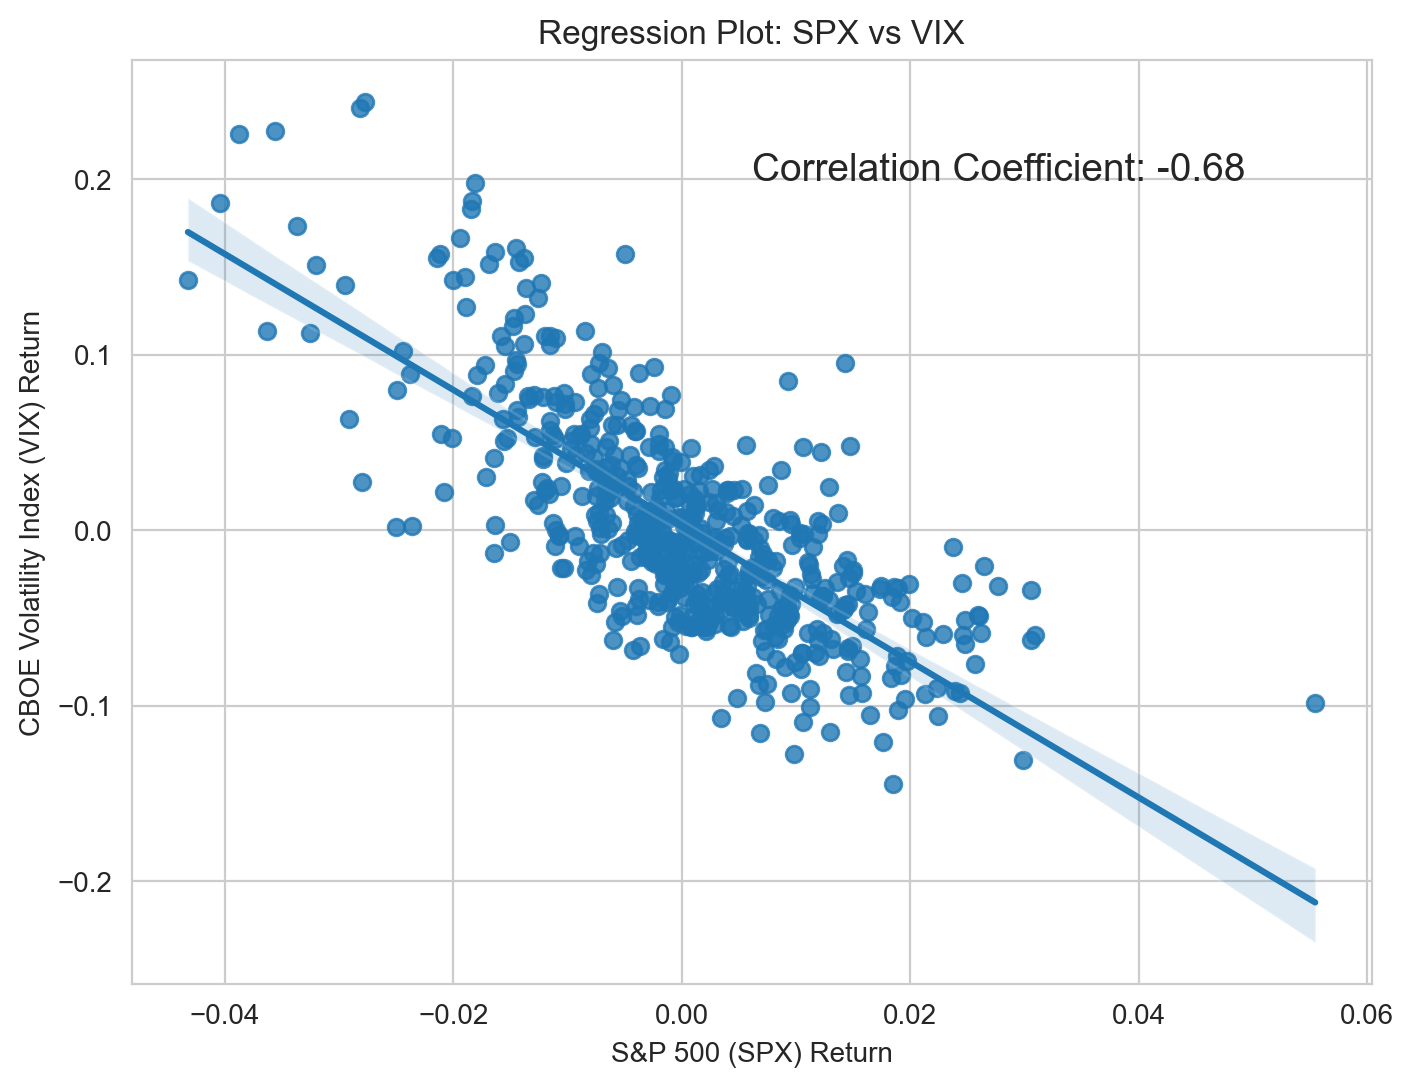

In [8]:
plt.figure(figsize=(8, 6), dpi=200)
ax = sns.regplot(x="SPX", y="VIX", data=df.pct_change())

# Calculate the correlation coefficient
corr_coef = df['SPX'].corr(df['VIX'])
ax.text(0.5, 0.9, f"Correlation Coefficient: {corr_coef:.2f}", transform=ax.transAxes, fontsize=14, verticalalignment='top')

# Add labels and title
plt.xlabel("S&P 500 (SPX) Return")
plt.ylabel("CBOE Volatility Index (VIX) Return")
plt.title("Regression Plot: SPX vs VIX")
plt.show()

# Cointegration Test


In [9]:
import statsmodels.tsa.stattools as ts
'''
Cointegration test: A technique used to find a potential correlation in a time series (long term)
Determines if the spread between the two assets are constant over time.
Null Hypothesis: Spread between series are non-stationary.
Uses the augmented Engle-Granger two-step cointegration test.
''';

p('P value for the augmented Engle-Granger two-step cointegration test:')
p('==='*30)
for i, col_i in enumerate(df.columns):
    for col_j in df.columns[i+1:]:
        cointegration_t_statistic, p_val, critical_values_test_statistic_at_1_5_10 = ts.coint(df[col_i], df[col_j])
        p(f'{col_i}&{col_j}: {p_val}')

P value for the augmented Engle-Granger two-step cointegration test:
SPX&VIX: 0.9654446841651786
SPX&VIXF: 0.9454954975048252
VIX&VIXF: 0.00010774867451269132


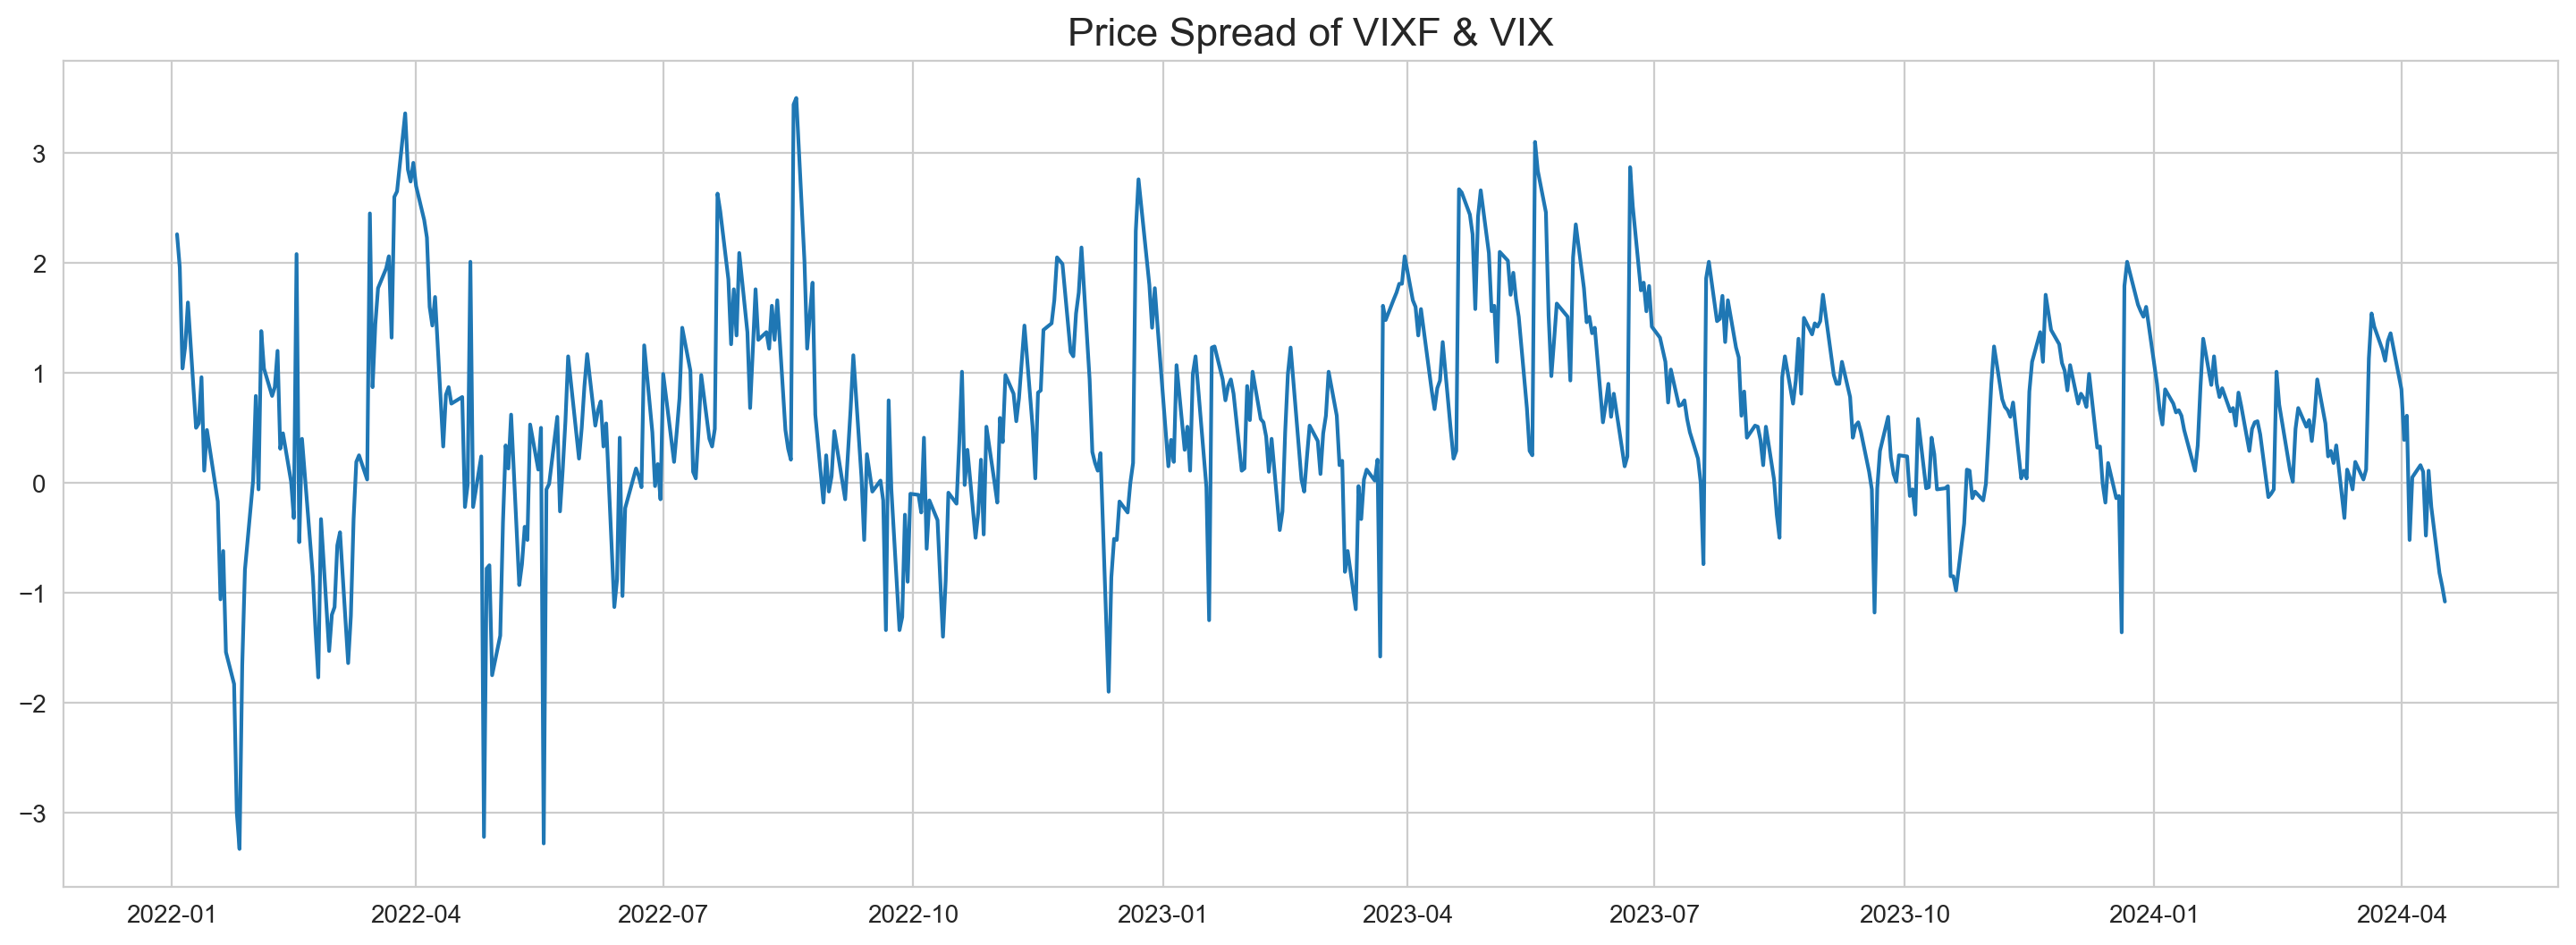

In [10]:
spread = df['VIXF'] - df['VIX']

fig = plt.figure(figsize=figsize, dpi=200)
plt.plot(spread.index, spread)
plt.title('Price Spread of VIXF & VIX', fontsize=16)
plt.show()

In [11]:
from scipy.signal import argrelextrema
def get_local_minimax(ds:pd.Series, order:int) -> pd.Series:
    ds = pd.DataFrame(ds)
    is_maxima_num_index = argrelextrema(ds.to_numpy(), np.greater, axis=0, order=order)[0]
    is_minima_num_index = argrelextrema(ds.to_numpy(), np.less, axis=0, order=order)[0]
    local_max_index_ls = []
    local_min_index_ls = []
    for i in is_maxima_num_index:
        if i > order and i <len(ds) - order:
            local_max_index_ls.append(ds.iloc[i:i+1].index)
    for i in is_minima_num_index:
        if i > order and i <len(ds) - order:
            local_min_index_ls.append(ds.iloc[i:i+1].index)      
    local_max_index_arr = np.array(local_max_index_ls).reshape(-1)
    local_min_index_arr = np.array(local_min_index_ls).reshape(-1)

    this_ds = ds.copy()
    this_ds[f'local minimax'] = 0
    this_ds.loc[local_max_index_arr, 'local minimax'] = -1
    this_ds.loc[local_min_index_arr, 'local minimax'] = 1
    return this_ds[f'local minimax']

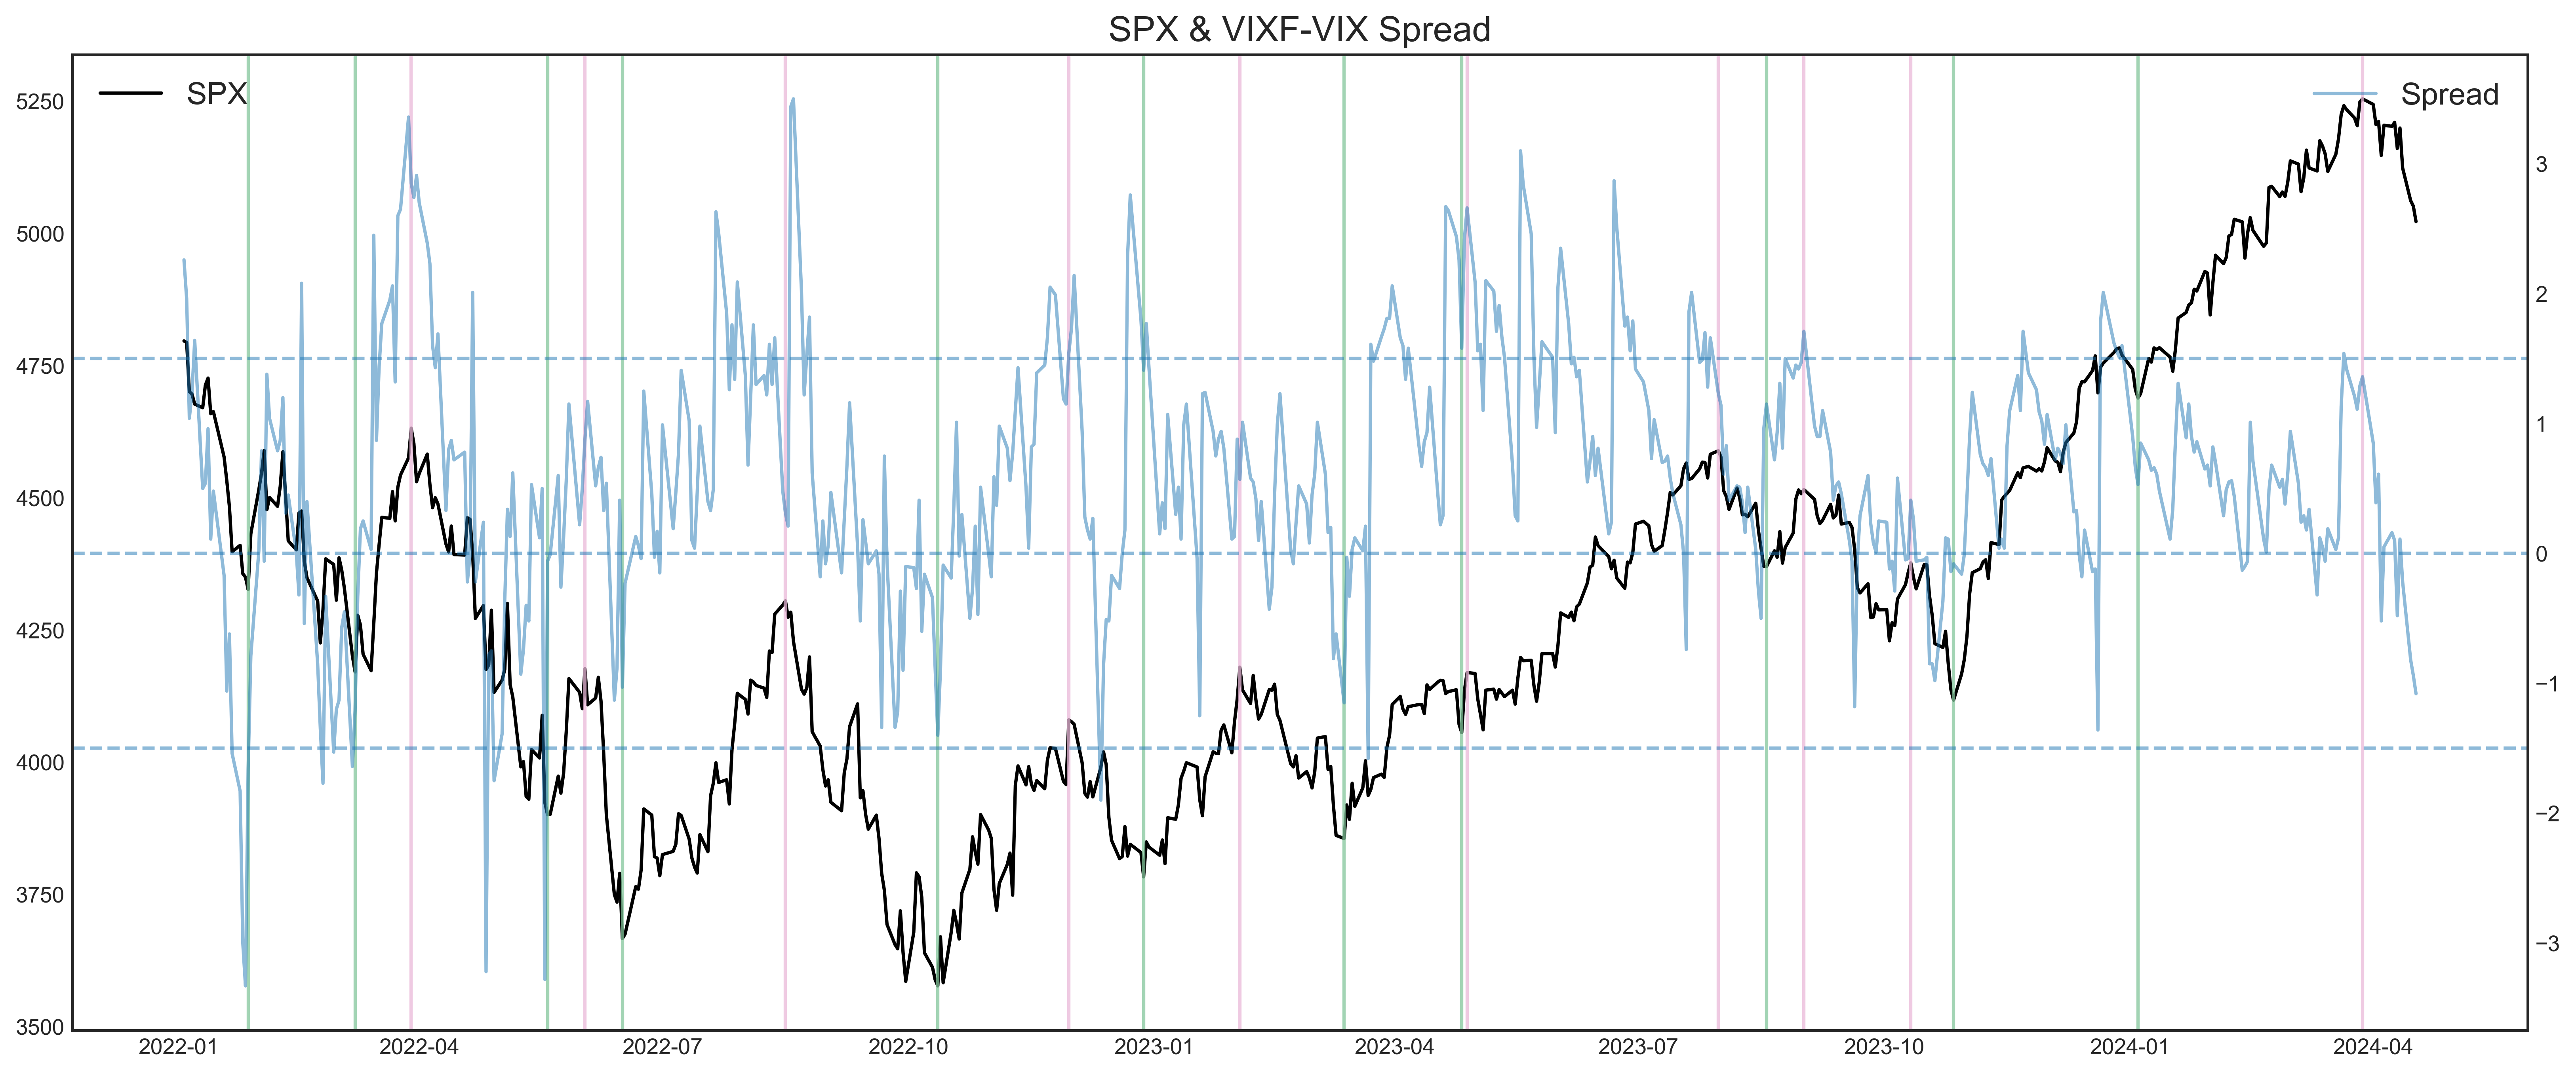

In [12]:
plt.style.use('seaborn-v0_8-white')
fig, ax1 = plt.subplots(figsize=(20, 8), dpi=400)
ax2 = ax1.twinx()

ax1_ds = df['SPX']
ax1.plot(ax1_ds, label='SPX', c='black', alpha=1)
ax1.legend(loc=2, fontsize=14)

minima_ds = df['SPX']
order = 13
for _x in minima_ds.loc[(get_local_minimax(minima_ds, order))==1].index:
    ax2.axvline(_x, color='#83c69b', alpha=0.75)   
for _x in minima_ds.loc[(get_local_minimax(minima_ds, order))==-1].index:
    ax2.axvline(_x, color='#eab9d9', alpha=0.75)  

ax2.plot(spread, label='Spread', c='#1f77b4', alpha=0.5)
ax2.legend(loc=1, fontsize=14)

ax2.axhline(0, alpha=0.5, linestyle='--')
ax2.axhline(1.5, alpha=0.5, linestyle='--')
ax2.axhline(-1.5, alpha=0.5, linestyle='--')

plt.title(f'SPX & VIXF-VIX Spread', fontsize=16)
plt.show()

# Transform

In [13]:
def smoothed_rolling_z(raw, window_sma: int, window_z: int):
    smoothed = raw.rolling(window_sma).mean()
    rolling_z = (smoothed - smoothed.rolling(window_z).mean()) / smoothed.rolling(window_z).std()
    return rolling_z

## Reverse

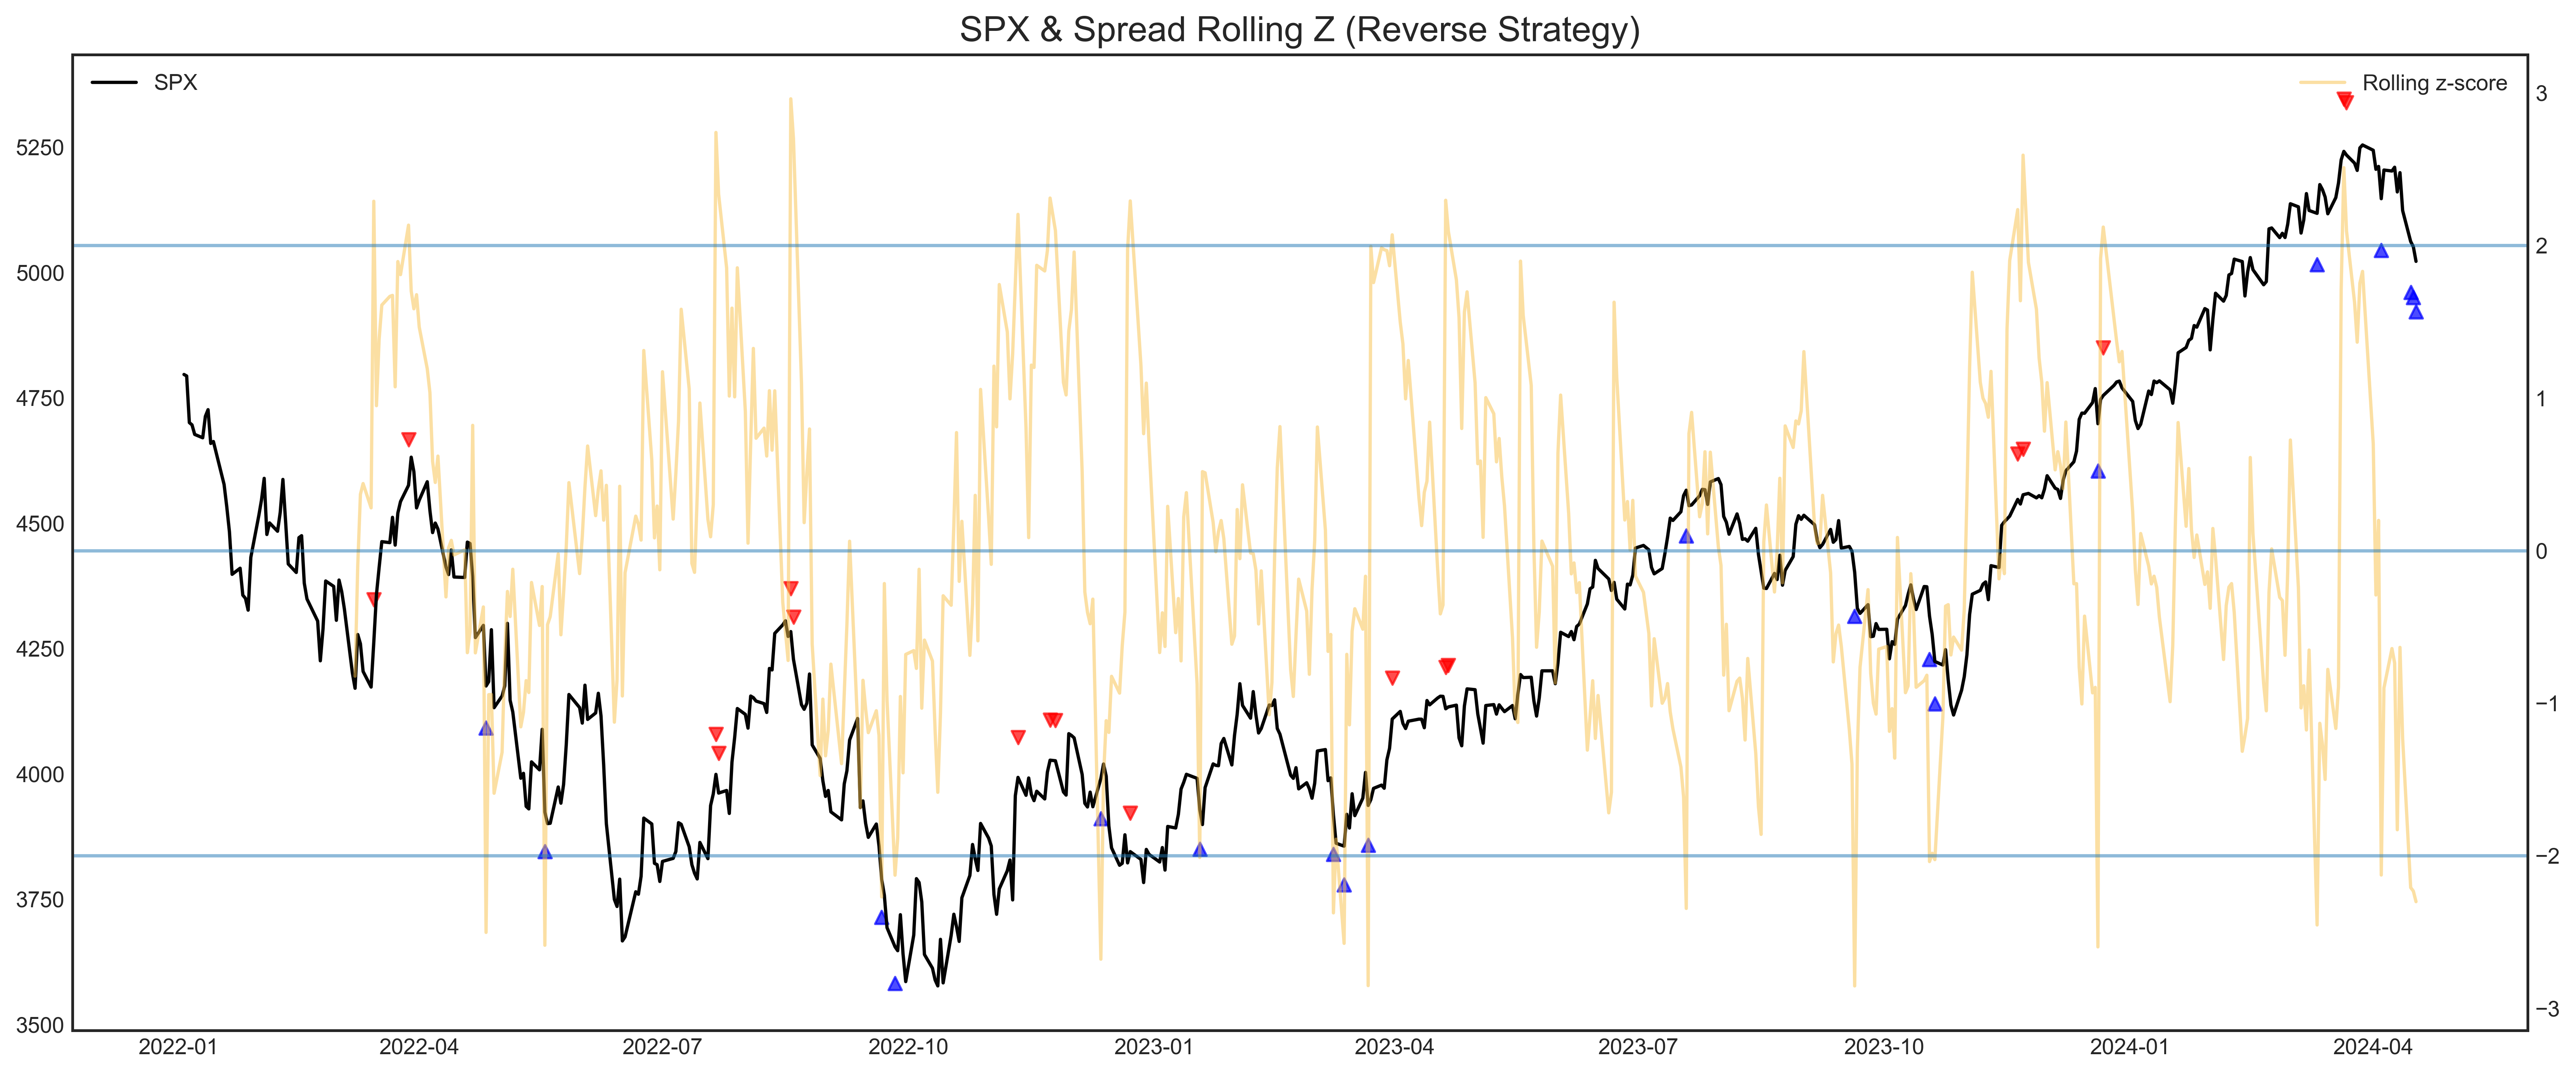

In [14]:
window_sma = 1
window_z = 45
rolling_z = smoothed_rolling_z(spread, window_sma, window_z)

upper_threshold = 2
lower_threshold = -2 # -upper_threshold
signals = pd.Series(np.select([(rolling_z>upper_threshold), (rolling_z<lower_threshold)], [-1, 1], 0), index=df.index)

fig, ax1 = plt.subplots(figsize=(20,8), dpi=400)
ax2 = ax1.twinx()

ax1.plot(df['SPX'], label='SPX', c='black', alpha=0.99)
scatter_long_idx = signals.loc[signals==1].index
scatter_short_idx = signals.loc[signals==-1].index
ax1.scatter(scatter_long_idx, df.loc[scatter_long_idx, 'SPX']*0.98, marker='^', c='blue', alpha=0.7)
ax1.scatter(scatter_short_idx, df.loc[scatter_short_idx, 'SPX']*1.02, marker='v', c='red', alpha=0.7)
ax1.legend(loc=2)

ax2.plot(rolling_z, label='Rolling z-score', c='#f9c049', alpha=0.5) #9c528b
ax2.legend(loc=1)
this = upper_threshold
for axhline in [-this, 0 , this]:
    ax2.axhline(axhline, alpha=0.5)

plt.title(f'SPX & Spread Rolling Z (Reverse Strategy)', fontsize=16)
plt.show()

## Minima

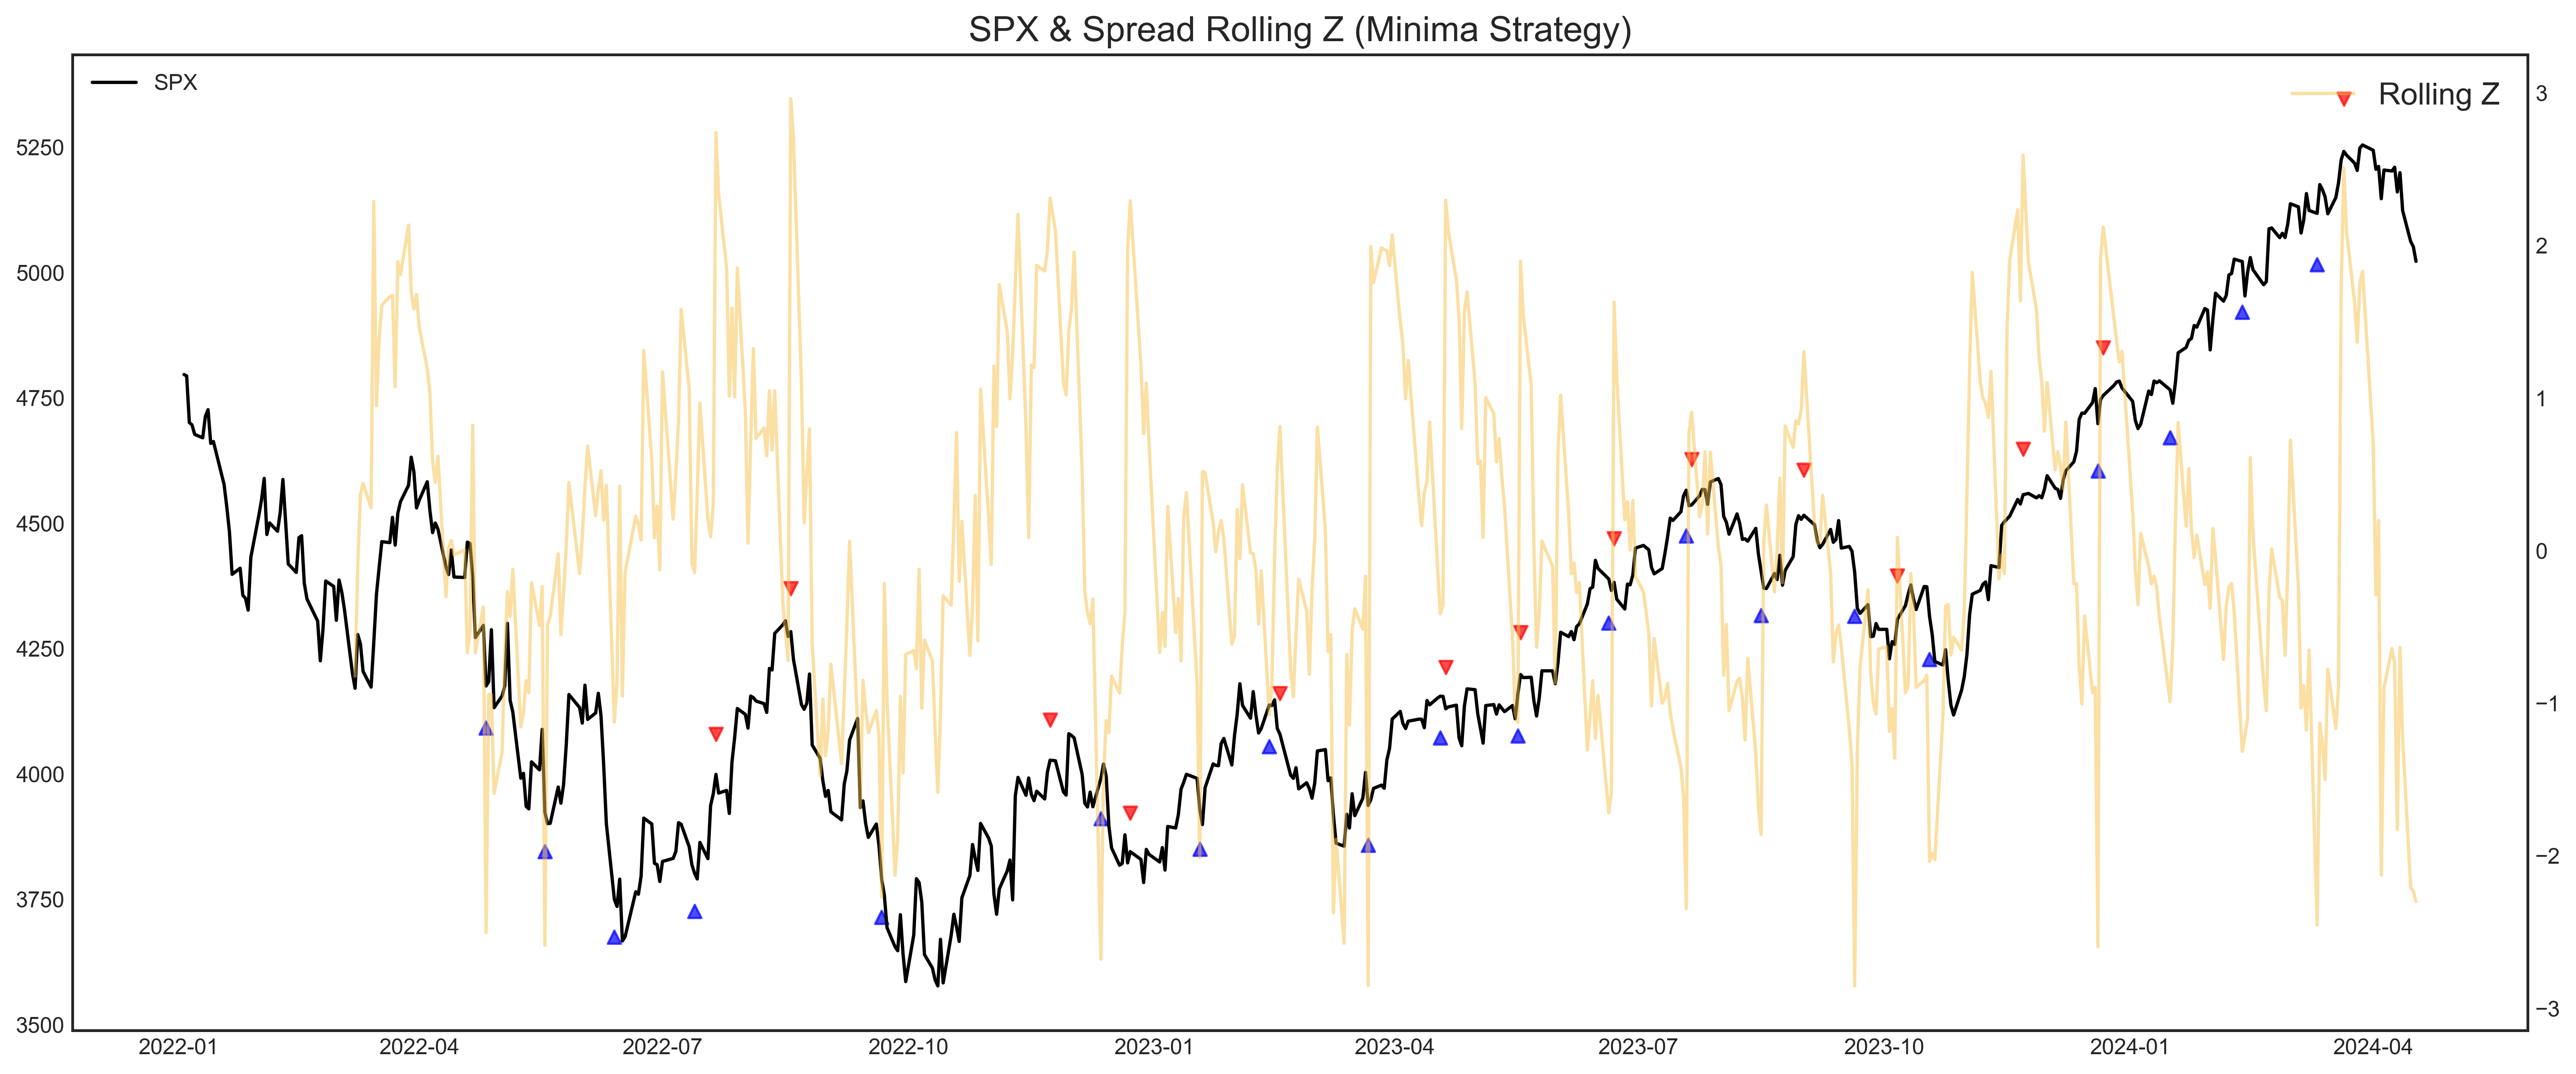

In [15]:
plt.style.use('seaborn-v0_8-white')
fig, ax1 = plt.subplots(figsize=(20, 8), dpi=400)
ax2 = ax1.twinx()

ax1_ds = df['SPX']
ax1.plot(ax1_ds, label='SPX', c='black', alpha=1)
ax1.legend(loc=2, fontsize=14)

minima_ds = rolling_z
order = 15
minima = get_local_minimax(minima_ds, order)

scatter_long_idx = minima.loc[minima==1].index
scatter_short_idx = minima.loc[minima==-1].index
ax1.scatter(scatter_long_idx, df.loc[scatter_long_idx, 'SPX']*0.98, marker='^', c='blue', alpha=0.7)
ax1.scatter(scatter_short_idx, df.loc[scatter_short_idx, 'SPX']*1.02, marker='v', c='red', alpha=0.7)
ax1.legend(loc=2)

# for _x in minima_ds.loc[minima==1].index:
#     ax2.axvline(_x, color='#83c69b', alpha=0.75)   
# for _x in minima_ds.loc[minima==-1].index:
#     ax2.axvline(_x, color='#eab9d9', alpha=0.75)  

ax2.plot(rolling_z, label='Rolling Z', c='#f9c049', alpha=0.5)
ax2.legend(loc=1, fontsize=14)

# ax2.axhline(0, alpha=0.5, linestyle='--')
# ax2.axhline(1.5, alpha=0.5, linestyle='--')
# ax2.axhline(-1.5, alpha=0.5, linestyle='--')

plt.title(f'SPX & Spread Rolling Z (Minima Strategy)', fontsize=16)
plt.show()

In [16]:
def calc_future_expected_return(_return, n):
    return _return[::-1].rolling(n).mean()[::-1].shift(-1)

# Split

In [17]:
df_train = df.iloc[:int(len(df)*0.7)].copy()
df_test = df.loc[df_train.index[-1]:].copy()

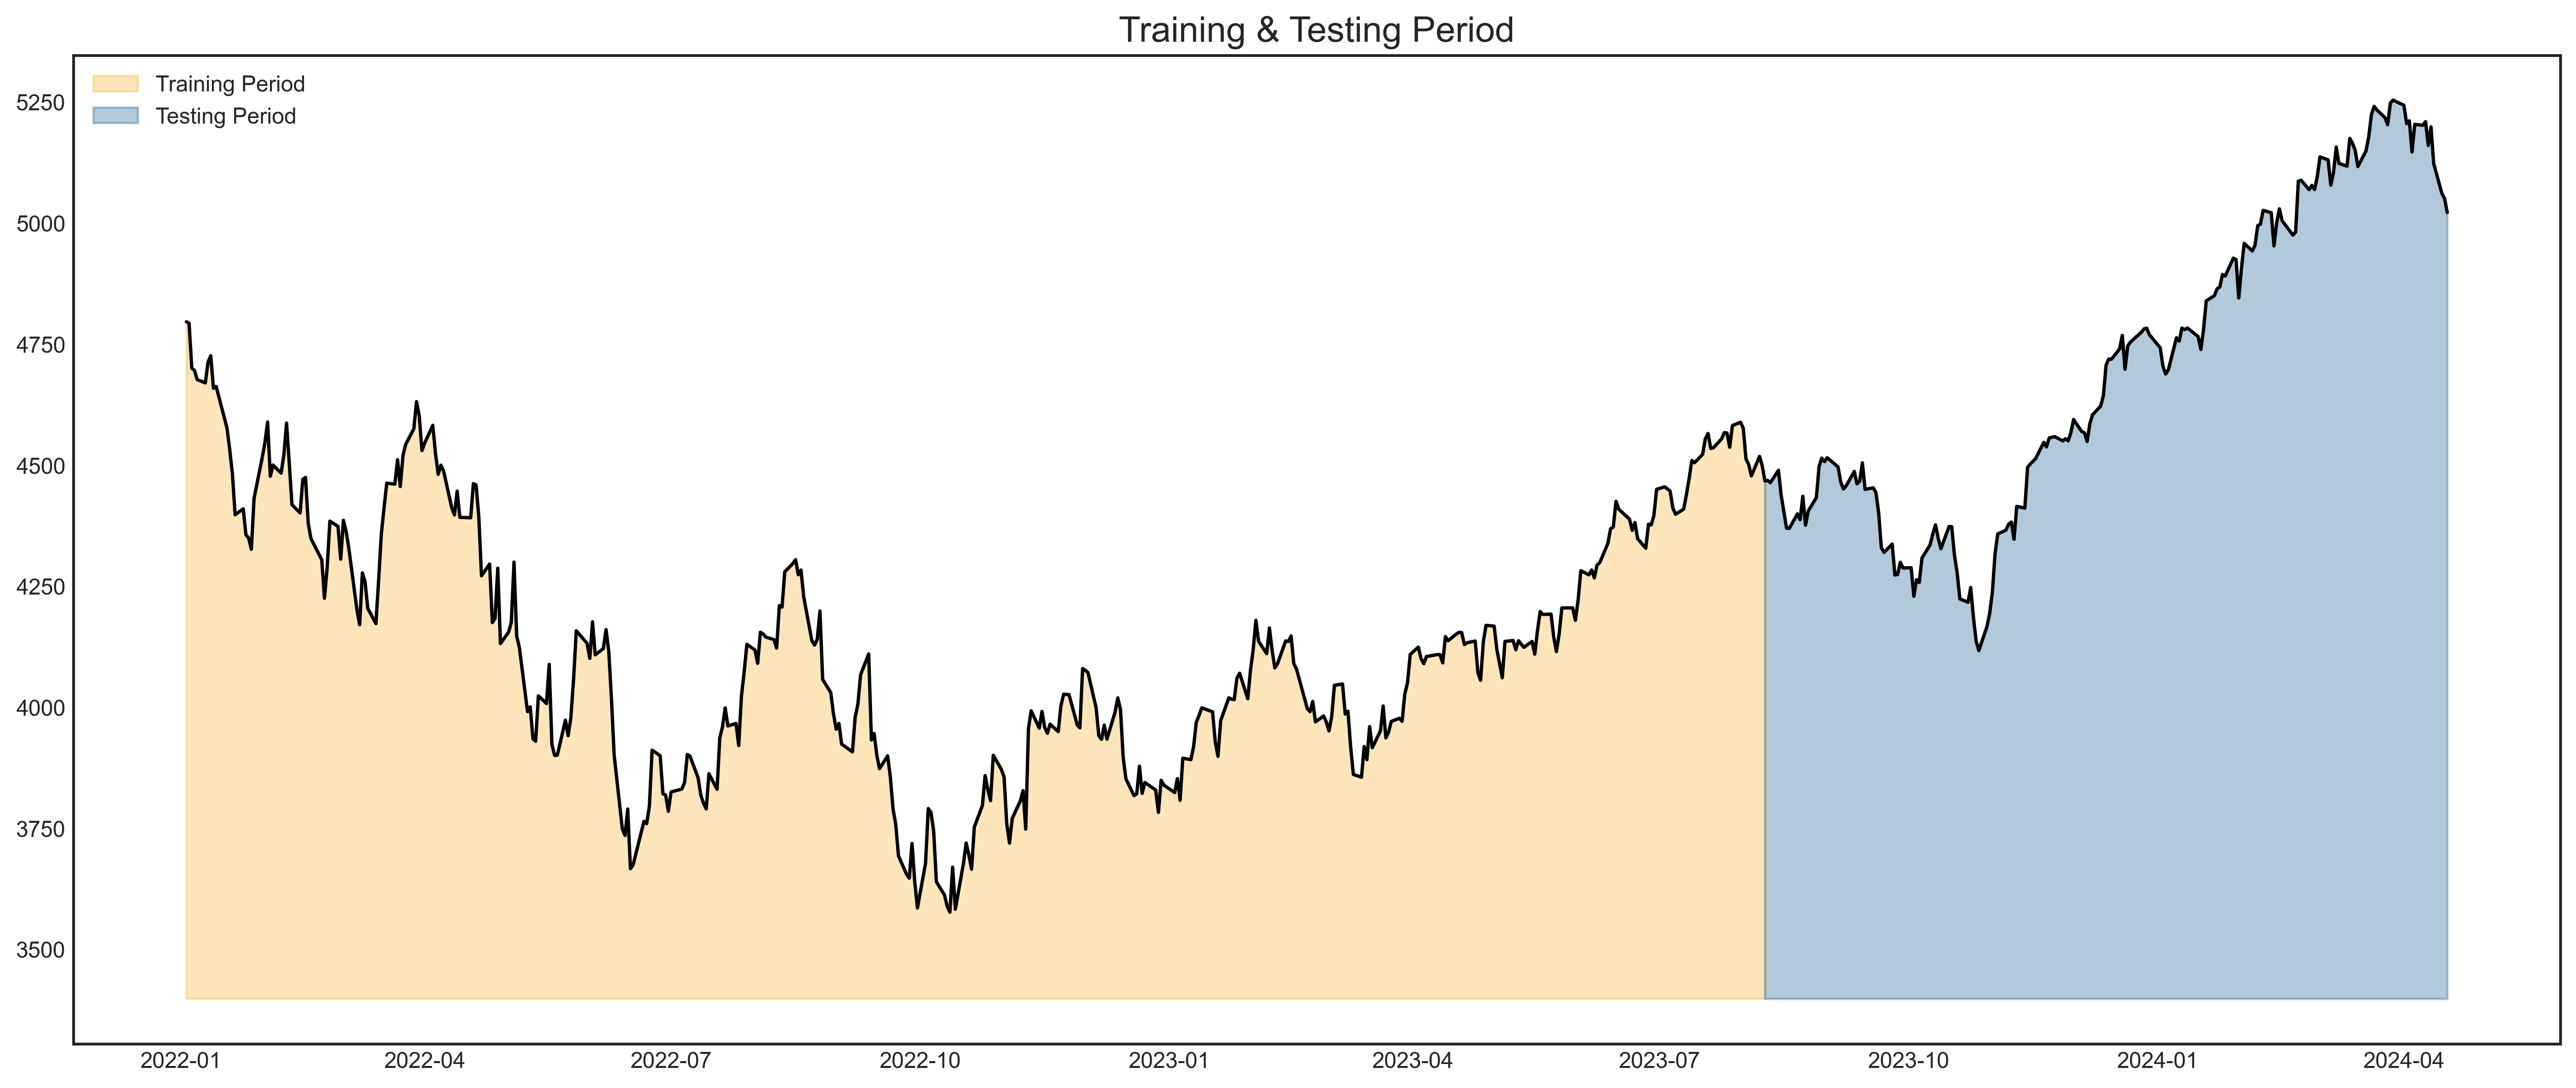

In [18]:
# Plotting the time series with train and test data
plt.figure(figsize=(20, 8), dpi=400)
plt.plot(df['SPX'], c='black')
plt.fill_between(df_train.index, df['SPX'].min()*0.95, df_train['SPX'], alpha=0.3, color='#f6aa1c', label='Training Period')
plt.fill_between(df_test.index, df['SPX'].min()*0.95, df_test['SPX'], alpha=0.3, color='#014f86', label='Testing Period')
# plt.xlabel('Time')
plt.ylabel('')
plt.title('Training & Testing Period', fontsize=16)
plt.legend()

plt.xticks(rotation=0)
plt.show()